In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import copy
import matplotlib.pyplot as plt
import pickle

In [ ]:
def pickle_save(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp)

In [ ]:
# load the dataframe
# dataset = pd.read_csv("data/training_datasets/combined_players_teams_lite.csv")
dataset = pd.read_csv("data/training_datasets/combined_players_teams_lite_w_min.csv")

In [ ]:
dataset

## Do transformations

In [ ]:
# create our X and y
y = dataset.gw_total_points.to_numpy()
X = dataset.drop("gw_total_points", axis=1)
cat_atts = list(X.columns[0:2])
num_atts = list(X.columns[2:])

In [ ]:
# train, validation, test split
X_train_raw, X_vali_test_raw, y_train_raw, y_vali_test_raw = train_test_split(X, y, train_size=0.8, shuffle=True)
X_vali_raw, X_test_raw, y_vali_raw, y_test_raw = train_test_split(X_vali_test_raw, y_vali_test_raw, train_size=0.5)

In [ ]:
# instantiate the transformers
# initial training found we performed better using a scaled target variable as there is a lot of variability
one_hot_enc = OneHotEncoder(sparse_output=False)
X_st_scaler = StandardScaler()
y_st_scaler = StandardScaler()

In [ ]:
# apply the y scaler to targets
y_train_scaled = y_st_scaler.fit_transform(y_train_raw.reshape(-1, 1))
y_vali_scaled = y_st_scaler.transform(y_vali_raw.reshape(-1, 1))
y_test_scaled = y_st_scaler.transform(y_test_raw.reshape(-1, 1))

In [ ]:
# build my pipelines
categorical_transformer = Pipeline(steps=[
    ('onehot', one_hot_enc),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', X_st_scaler),
])

# create the column transformer
fpl_preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_atts),
        ('num', numeric_transformer, num_atts),
    ]
)

In [ ]:
# apply transformations to features
transformed_X_train = fpl_preprocess.fit_transform(X_train_raw)
transformed_X_vali = fpl_preprocess.transform(X_vali_raw)
transformed_X_test = fpl_preprocess.transform(X_test_raw)

In [ ]:
X_train_tens = torch.tensor(transformed_X_train, dtype=torch.float32)
X_vali_tens = torch.tensor(transformed_X_vali, dtype=torch.float32)
X_test_tens = torch.tensor(transformed_X_test, dtype=torch.float32)
y_train_tens = torch.tensor(y_train_scaled, dtype=torch.float32).reshape(-1, 1)
y_vali_tens = torch.tensor(y_vali_scaled, dtype=torch.float32).reshape(-1, 1)
y_test_tens = torch.tensor(y_test_scaled, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# create datasets
train_dataset = TensorDataset(X_train_tens, y_train_tens)
vali_dataset = TensorDataset(X_vali_tens, y_vali_tens)
test_dataset = TensorDataset(X_test_tens, y_test_tens)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# save our pipeline for future use
pickle_save(fpl_preprocess, "fpl_preprocess.pkl")
pickle_save(y_st_scaler, "y_st_scaler.pkl")

## Modelling

I tried a number of model architectures with different depths and widths, but this was found as the best one

I also tried:
- learning_rate = [0.01, 0.001, 0.0001, 0.00001]
- momentum = [0.85, 0.9, 0.99]
- activation_function = [ReLU(), LeakyReLU()]
- gradient_clipping = nn.utils.clip_grad_norm_(model.parameters(), 1.0)
- weight_decay = [0.0001]

And found the following representation as the one which minimised loss

In [ ]:
# define our model and optimize the weights

layer_0 = nn.Linear(88, 6000)
nn.init.kaiming_uniform_(layer_0.weight, mode='fan_in', nonlinearity='leaky_relu')

layer_1 = nn.Linear(6000, 2000)
nn.init.kaiming_uniform_(layer_1.weight,mode='fan_in', nonlinearity='leaky_relu')

layer_2 = nn.Linear(2000, 500)
nn.init.kaiming_uniform_(layer_2.weight, mode='fan_in', nonlinearity='leaky_relu')
# 
layer_4 = nn.Linear(500, 25)
nn.init.kaiming_uniform_(layer_4.weight, mode='fan_in', nonlinearity='leaky_relu')

layer_5 = nn.Linear(25, 1)
nn.init.kaiming_uniform_(layer_5.weight, mode='fan_in', nonlinearity='leaky_relu')

model = nn.Sequential(
    layer_0,
    nn.LeakyReLU(),
#     nn.Dropout(p=0.05),
    layer_1,
    nn.LeakyReLU(),
#     nn.Dropout(p=0.05),
    layer_2,
    nn.LeakyReLU(),
    layer_4,
    nn.LeakyReLU(),
#     nn.Dropout(p=0.05),
    layer_5
)

In [ ]:
# loss function, optimizer, epochs and bactch size
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.95) #, weight_decay = 0.0001)
n_epochs = 100
batch_size = 64

In [ ]:
# hold our best model weights to save later

best_mse = np.inf   # init to infinity
best_weights = None
train_history = {}
vali_history = {}

# train loop
for epoch in range(n_epochs):
    
    # set to train mode
    model.train()
    
    # set train loss
    train_loss = 0.0
    
    # loop through the dataloader
    for train_data in train_dataloader:
        
        # get features and target
        features, target = train_data
        
        # forward pass
        y_pred = model(features)
        loss = loss_fn(y_pred, target)
        
        # update metrics
        train_loss += loss.item()*features.size(0)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()
        
    
    # VALIDATION
    
    with torch.no_grad():
        
        # set model to eval mode
        model.eval()
        
        # forward pass
        y_pred = model(X_vali_tens)
        mse = loss_fn(y_pred, y_vali_tens)
        mse = mse.item()
        
        # update metrics
        vali_history[epoch] = float(mse)
        train_history[epoch] = float(train_loss/len(train_dataset))
        
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
            
    
    # make a pretty plot
    print("BEST MSE: %.2f" % best_mse)
    print("BEST RMSE: %.2f" % np.sqrt(best_mse))
    
    plt.plot(train_history.keys(), train_history.values(), label='Training Loss')
    plt.plot(vali_history.keys(), vali_history.values(), label='Validation Loss')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Set the tick locations
    plt.xticks(np.arange(0, n_epochs, 5))

    # Display the plot
    plt.legend(loc='best')
    plt.show()

# load the best weights after training
model.load_state_dict(best_weights)

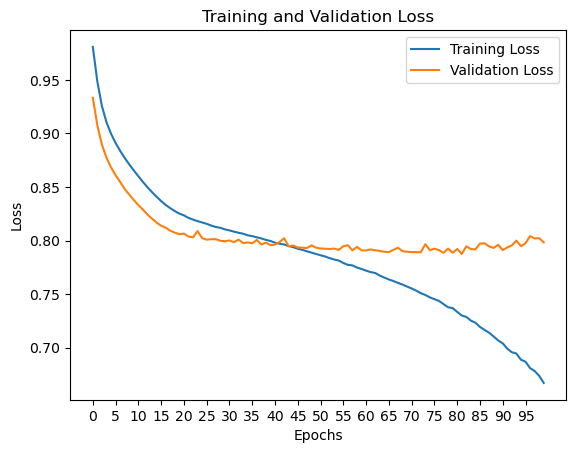

In [24]:
plt.plot(train_history.keys(), train_history.values(), label='Training Loss')
plt.plot(vali_history.keys(), vali_history.values(), label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, n_epochs, 5))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
def accuracy(model, X_test, y_test, pct):
    
    n_correct = 0 
    n_wrong = 0
    model.eval()
    with torch.no_grad():
        for i in range(len(X_test)):
            X_sample = X_test[i: i+1]
            actual = y_test[i].numpy()
            preds = model(X_sample)
            y_pred_upscale = y_st_scaler.inverse_transform(preds)
            y_target = y_st_scaler.inverse_transform(y_test_scaled)[i]

            print("-----------------------------")
            abs_delta = np.abs(round(y_pred_upscale.item()) - y_target.item())
            max_allow = np.abs(pct * y_target.item())
            print("predicted = %0.4f  actual = %0.4f \ delta = %0.4f  max_allow = %0.4f : " % (round(y_pred_upscale.item()), y_target.item(), abs_delta, max_allow),  end="")
            if abs_delta < max_allow:
                print("correct")
                n_correct +=1
            else:
                print("wrong")
                n_wrong += 1

    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    return acc

In [ ]:
acc = accuracy(model, X_test_tens, y_test_tens, 0.20)

In [25]:
acc

0.21360592174832568

### Results

As we can see, predicting the weekly results is hard, and we were only within 20% of the actual score for each player ~21.3% of the time, which is not very accurate.

However, to be a good tool, the model doesn't necessarily have to be incredibly accurate, it just has to predict the highest scoring player each week (or at least be accurate over an extended period).

I think having an accurate model for predictions on a specific gameweek is always going to be hard, becuase there is a huge amount of randomness guiding a player's points tally, which will never be captured in the stats.

Because of this, I think the weekly predictor should only be used as a guide to selecting players, not necessarily as an accurate predictor of points

Next steps are to see if the model is accurate over an extended period (e.g. a season) and plot players' predicted vs actual cumulative points. That way I can at least see if the model can be used to guid judgements over the longer term.